# OpenClassrooms - projet 3
## OpenFoodFacts

Contexte : élaborer une idée d'application exploitant les données fournies par Open Food Facts.

Idée d'application : estimer le nutriscore d'un produit. Le nutri-score des aliments repose sur le calcul d’un score unique et global prenant en compte, pour chaque aliment :

- une composante dite « négative » N composée des nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- une composante dite « positive » P composée des nutriments à limiter (énergie, acides gras saturés, sucres, sel).

Il convient de réaliser une exploration des données pour sélectionner les variables les plus pertinentes pour estimer le nutriscore.

## Imports and config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, requests, os, urllib.request
from tqdm import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')
tqdm.pandas()
pd.set_option("display.max_columns", 200)

In [3]:
storage_path = os.path.join('..', 'data')
filepath = os.path.join(storage_path, 'en.openfoodfacts.org.products.pkl')
#df = pd.read_pickle(filepath)

## EDA

In [5]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615984 entries, 0 to 1615983
Data columns (total 184 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   code                                        1615984 non-null  object 
 1   url                                         1615984 non-null  object 
 2   creator                                     1615980 non-null  object 
 3   created_t                                   1615984 non-null  int64  
 4   created_datetime                            1615984 non-null  object 
 5   last_modified_t                             1615984 non-null  int64  
 6   last_modified_datetime                      1615984 non-null  object 
 7   product_name                                1526408 non-null  object 
 8   abbreviated_product_name                    922 non-null      object 
 9   generic_name                                109723 non-n

In [8]:
# fetching features categories
url = 'https://world.openfoodfacts.org/data/data-fields.txt'
features_description = requests.get(url).text
features_dict = {i.split('\n\n')[0].strip()[:-1]: 
                 [j.split(':')[0].strip() for j in i.split('\n\n')[1].strip().split('\n')]
                 for i in features_description.split('#')[1:]}

In [4]:
# clean features names
df.columns = [c[1:] if c.startswith('-') else c for c in df.columns]

### Train test split

Pour ne pas biaisier l'analyse exploratoire des données et a fortiori le futur modèle, il convient de déviser le jeu de données:
- un jeu de prédiction (données non labelisées)
- un jeu de test (20%)
- un jeu d'entrainement (80%)

In [5]:
df_no_lab = df.loc[df.nutriscore_score.isna()]
df_lab = df.loc[df.nutriscore_score.notna()]

In [6]:
X = df_lab.drop(columns = ['nutriscore_grade'])
y = df_lab.nutriscore_grade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [7]:
df_train = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
df_test = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)

In [8]:
# save and clear memory
df_no_lab.to_pickle(os.path.join(storage_path, 'pred_set.pkl'))
df_train.to_pickle(os.path.join(storage_path, 'train_set.pkl'))
df_test.to_pickle(os.path.join(storage_path, 'test_set.pkl'))

del df
del df_no_lab
del df_test
del X
del y
del X_train
del X_test
del y_train
del y_test

In [4]:
df_train = pd.read_pickle(os.path.join(storage_path, 'train_set.pkl'))

In [6]:
df_train.shape

(502992, 184)

### Missing values

Analyse des valeurs manquantes doit se réaliser uniquement sur les produits qui ont un nutriscore puisque ce sont nos données labélisées.

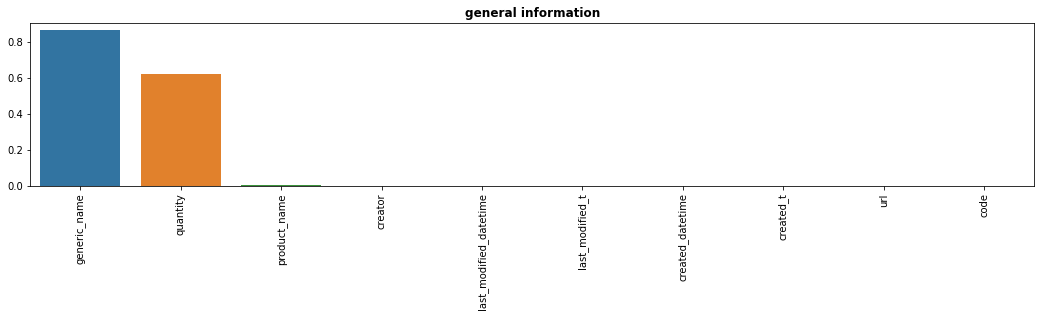

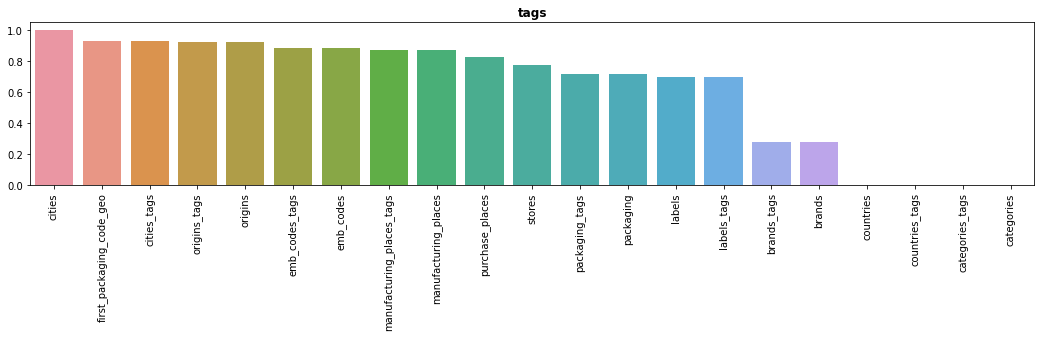

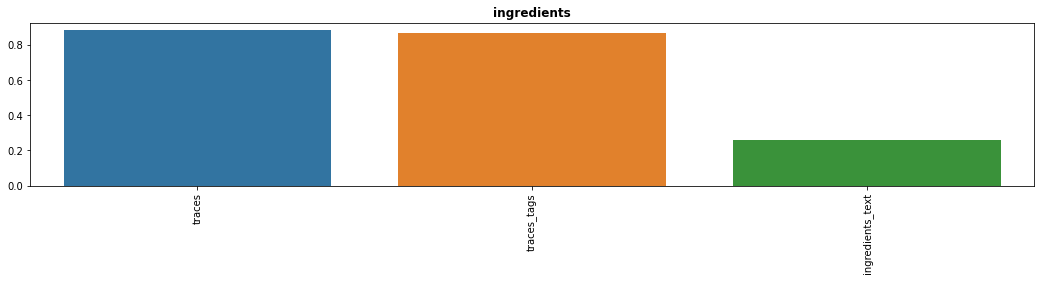

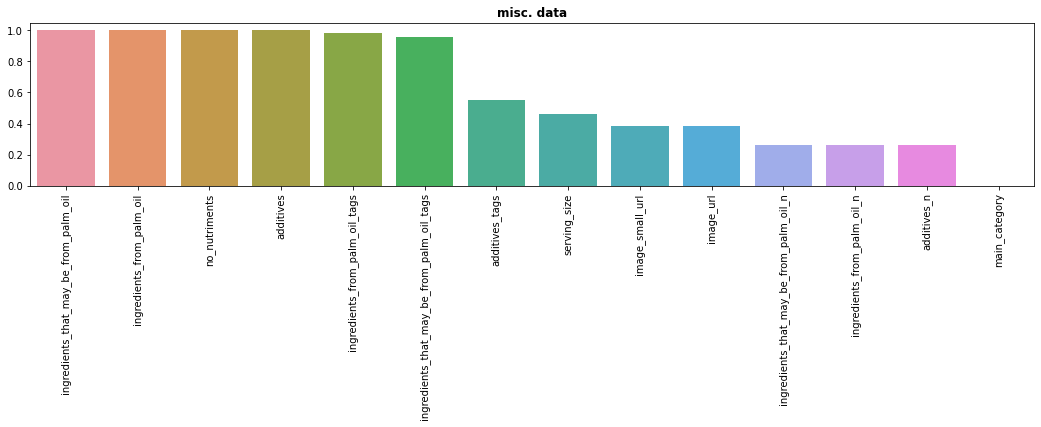

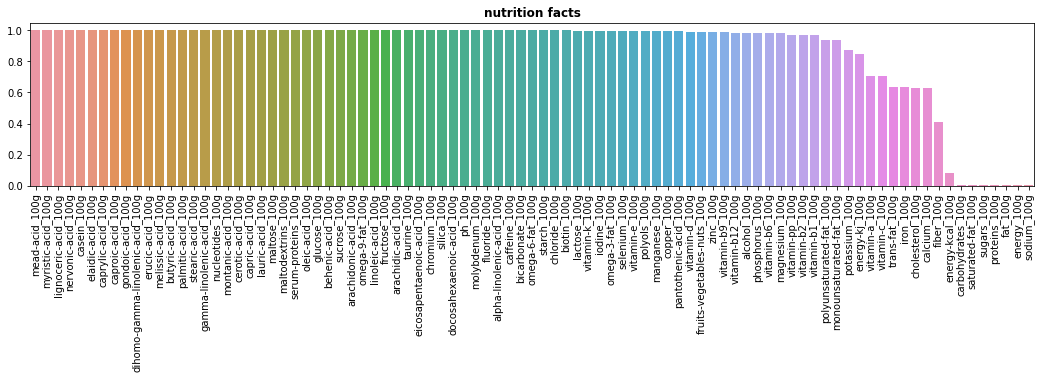

In [9]:
for cat in features_dict.keys():
    features = df_train.columns[df_train.columns.isin(features_dict[cat])]
    serie = (df_train[features].isnull().sum() / len(df_train[features])).sort_values(ascending = False)
    plt.figure(figsize = (18, 3))
    plt.title(cat, weight = 'bold')
    sns.barplot(serie.index, serie.values)
    plt.xticks(rotation = 90)
    plt.show()

Dans un premier temps on va explorer les variables liés aux valeurs nutritionnelles qui sont les plus complètes: [lien github](https://github.com/leoguillaume/openclassrooms-project-3/blob/main/src/2021022520%-20%Nutrition20%facts20%exploration.ipynb)

Toutefois, il y a beaucoup de valeur nulles pour les valeurs nutritionnelles des produits. De plus, le nutri-score des aliments repose sur le calcul d’un score unique et global prenant en compte, pour chaque aliment :

- une composante dite « négative » N composée des nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- une composante dite « positive » P composée des nutriments à limiter (énergie, acides gras saturés, sucres, sel).

Autrements dit le nutri-score d'un produit se calcule sur la base des valeurs nutritionnelles des aliments qui le compose, cela n'apporte pas de plus-value de réaliser la prédiction d'un score sur les éléments qui le compose. 

Dans un second temps nous allons donc nous epxlorer la possibilité d'estimer le nutriscore à travers d'autres variables que liées aux valeurs nutritionnelles. A l'issue de l'exploration de ces variables ci-dessous, deux variables sont interessante à explorer: image_url ([repo github]()) et ingredients ([repo github]()). 

### Exploration des variables hors champs nutritionnel

In [10]:
# features without nutrition facts
_features = [f for key, value in features_dict.items() for f in value if key != 'nutrition facts']

In [11]:
# remove features in documentation that are not in dataframe
_features = list(set(_features).intersection(set(df.columns)))

Dans ces features certaines attraient à seulement à des considérations autres que les produits, comme code ou url, il convient de les supprimer.

In [12]:
_features_to_remove = ['code', 'url', 'creator', 'created_datetime', 'created_t', 'last_modified_datetime', 'last_modified_t']

_features = [f for f in _features if f not in _features_to_remove]

In [13]:
len(_features)

41

In [14]:
df_train_wo_nutri_facts = df_train[_features]

In [15]:
_serie = (df_train_wo_nutri_facts.isnull().sum() / len(df_train_wo_nutri_facts)).sort_values(ascending = False)

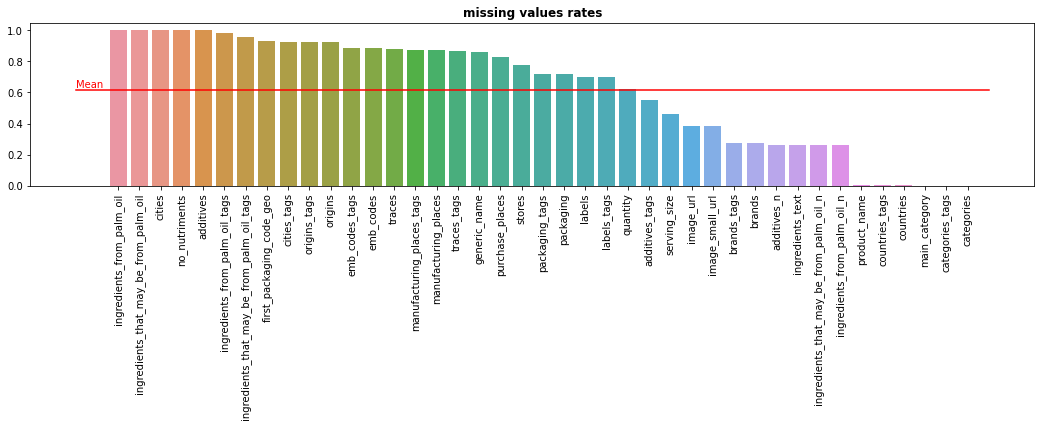

In [16]:
plt.figure(figsize = (18, 3))
plt.title('missing values rates', weight = 'bold')
sns.barplot(_serie.index, _serie.values)
plt.xticks(rotation = 90)
x = np.arange(-2, len(_features) + 1)
y = np.ones(len(_features) + 3)*_serie.mean()
plt.plot(x, y, c = 'red')
plt.text(x = -2, y = _serie.mean() + 0.02, s = 'Mean', c = 'red')
plt.show()

In [17]:
# missing values rates statistical description
round(_serie.describe(), 3)

count    41.000
mean      0.615
std       0.357
min       0.000
25%       0.277
50%       0.716
75%       0.923
max       1.000
dtype: float64

Le taux de valeurs manquantes est pour la moitié des variables supérieur à 71% ce qui reste très élevé. In convient d'exclure les variables dont le taux est supérieur à la moyenne des taux de valeur manquantes (61,5%).

In [18]:
_feature_to_keep = _serie[_serie < _serie.mean()].index.tolist()
_feature_to_keep += ['nutriscore_score', 'nutriscore_grade']

In [19]:
df_train_wo_nutri_facts = df_train_wo_nutri_facts[_feature_to_keep]

Dans ces variables restantes je retire les variables qui sont liées aux valeurs nutritionnelles du produits.

In [ ]:
_feature_to_remove = [
    'additive_tags',
    'serving_size', 
    'additive_n', 
    'ingredients_that_may_be_from_palm_oil_n', 
    'ingredients_from_palm_oil_n',
    'nutriscore_score',
    'nutriscore_grade',
]

In [ ]:
df_train_wo_nutri_facts = df_train_wo_nutri_facts[~_feature_to_remove]

In [26]:
_serie = (df_train_wo_nutri_facts.isnull().sum() / len(df_train_wo_nutri_facts)).sort_values(ascending = False)

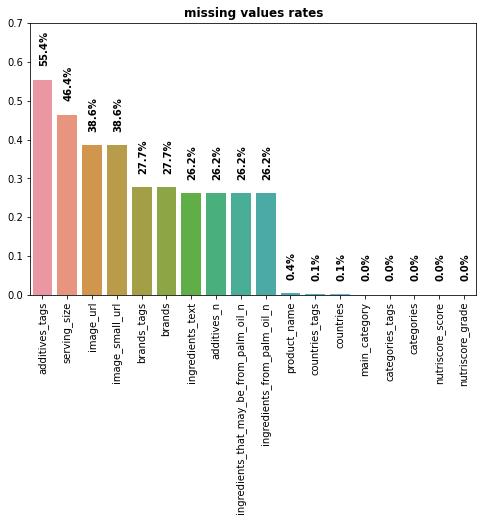

In [28]:
plt.figure(figsize = (8, 5))
plt.title('missing values rates', weight = 'bold')
sns.barplot(_serie.index, _serie.values)
plt.xticks(rotation = 90)


for i in range(len(_serie)):
    plt.text(x = i - 0.15,
             y = _serie.values[i] + 0.04,
             s = f'{_serie.values[i]:.1%}',
             fontweight = 'bold',
             rotation = 90)

plt.gca().set_ylim([0,0.7])
plt.show()

Parmis ces variables restantes, deux semblent particulièrement interressante en vue d'une application d'estimation du nutriscore : image_url et ingredients_text.

L'idée étant qu'il peut être pertinent d'estimer le nutriscore à partir d'une photo d'un produit affichant ces ingredients. Cependant ces deux sources de données sont des données non structurées. Ce qui signifie qu'il faut extraire des variables exploitables de ces données.


- extraire des variables d'images voir [Kumar & Kumar Bhatia, 2014](https://www.researchgate.net/publication/260952140_A_Detailed_Review_of_Feature_Extraction_in_Image_Processing_Systems))   
   

- additives_tags :
    - split et convertir en dummies variables
    - knn imputer (ajouter le reste des variables ?) (sans nutriscore)


- serving_size :    
    - extraire uniquement le poids en gramme
    - regarder si valeurs abérantes, si oui les supprimer ou appliquer une normalisation
    - knn imputer (ajouter le reste des variables ?) (sans nutriscore)
   
   

- brands_tags:
    - doublons avec brands mais à privilégié car moins de valeur unique
    - normaliser en passant en lower
    - split et convertir en dummies variables 
    - imputation avec brands à l'aide d'un dictionnaire d'équivalence 
    - knn imputer (completer avec store ?) (sans nutriscore)
    
    
- brands:
    - à supprimer après preprocessing de brands_tags
    


  
  
- ingredients_that_may_be_from_palm_oil_n:
    - regarder si valeurs abérantes, si oui les supprimer ou appliquer une normalisation
    - knn imputer
    
- ingredients_from_palm_oil_n:
    - idem que ingredients_that_may_be_from_palm_oil_n
    
- additives_n:
    - idem que ingredients_that_may_be_from_palm_oil_n 

> **/!\ appliquer l'imputation des données manquantes après préprocessing de l'ensemble des variables et après l'analyse des corrélations (sinon celle-ci sera biaisée)**


Remarque : regarder novagroup, sugar, protein

## Data preprocessing

### additives_tags

In [31]:
_serie = _df_train.additives_tags.str.replace('en:', '').str.split(',')
_series =  pd.get_dummies(_serie.dropna().apply(pd.Series).stack(), prefix = 'add').sum(level = 0)
_features = [c for c in _series.columns if len(c) < 11]
_series = _series[_features]
_df_train = _df_train.merge(_series, left_index = True, right_index = True, how = 'left')

In [32]:
del _series

In [33]:
_df_train.drop(columns = 'additives_tags', inplace = True)

In [34]:
_df_train.shape

(502992, 502)

### serving_size 

In [35]:
def serving_size_preprocessing(_v):
    pat = '([0-9]+,[0-9]+\s+x)|([0-9]*\.[0-9]+\s+x)|([0-9]+\.[0-9]+x)|([0-9]+,[0-9]+x)|([0-9]+x)|([0-9]+\s+x)'
    try:
        _v = _v.lower()
        metric = 'g' 
        _pat = re.sub('x', metric, pat)
        if re.search(_pat, _v):
            _r = re.search(_pat, _v).group()
            _r = re.sub(metric, '', _r)
            _r = re.sub(',', '.', _r)
            return float(_r.strip())
        else:
            metric = 'ml' 
            _pat = re.sub('x', metric, pat)
            if re.search(_pat, _v):
                _r = re.search(_pat, _v).group()
                _r = re.sub(metric, '', _r)
                _r = re.sub(',', '.', _r)
                return float(_r.strip())
            else:
                metric = 'l' 
                _pat = re.sub('x', metric, pat)
                if re.search(_pat, _v):
                    _r = re.search(_pat, _v).group()
                    _r = re.sub(metric, '', _r)
                    _r = re.sub(',', '.', _r)
                    return float(_r.strip()) * 1000
                else:
                    metric = 'cl' 
                    _pat = re.sub('x', metric, pat)
                    if re.search(_pat, _v):
                        _r = re.search(_pat, _v).group()
                        _r = re.sub(metric, '', _r)
                        _r = re.sub(',', '.', _r)
                        return float(_r.strip()) * 10
                    else:
                        metric = 'oz' 
                        _pat = re.sub('x', metric, pat)
                        if re.search(_pat, _v):
                            _r = re.search(_pat, _v).group()
                            _r = re.sub(metric, '', _r)
                            _r = re.sub(',', '.', _r)
                            return float(_r.strip()) * 28.3495
                        else:
                            metric = 'kg' 
                            _pat = re.sub('x', metric, pat)
                            if re.search(_pat, _v):
                                _r = re.search(_pat, _v).group()
                                _r = re.sub(metric, '', _r)
                                _r = re.sub(',', '.', _r)
                                return float(_r.strip()) * 1000

    except:
        return np.NaN

In [36]:
_df_train.serving_size = _df_train.serving_size.progress_apply(serving_size_preprocessing)

100%|██████████| 502992/502992 [00:08<00:00, 56830.89it/s]


In [37]:
_df_train.serving_size.describe()

count     268799.000000
mean          95.166568
std         2111.478895
min            0.000000
25%           29.000000
50%           52.000000
75%          113.000000
max      1000000.000000
Name: serving_size, dtype: float64

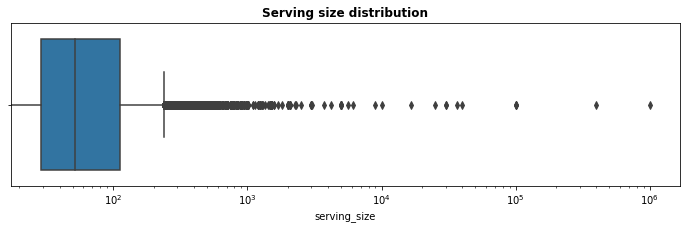

In [38]:
plt.figure(figsize=(12, 3))
sns.boxplot(_df_train.serving_size)
plt.title('Serving size distribution', weight ='bold')
plt.xscale('log')
plt.show()

In [39]:
_df_train.serving_size.quantile(0.9999)

3000.0

In [40]:
(_df_train.serving_size > _df_train.serving_size.quantile(0.9999)).sum()

25

In [41]:
_df_train = _df_train.loc[_df_train.serving_size < _df_train.serving_size.quantile(0.9999)]

### image_small_url 

In [42]:
_df_train.drop(columns = 'image_small_url', inplace = True)

### image_url 

In [49]:
for index, url in tqdm(_df_train.image_url.dropna().iteritems()):
    try:
        urllib.request.urlretrieve(url, os.path.join(storage_path, 'images', str(index) + '.jpg'))
    except:
        print(url)

847it [02:02,  7.55it/s]

https://static.openfoodfacts.org/images/products/431/150/163/4295/front_fr.4.400.jpg


8824it [25:38,  6.17it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.5.400.jpg


14606it [43:22,  5.58it/s]

https://static.openfoodfacts.org/images/products/325/654/001/0710/front_fr.4.400.jpg


33229it [1:38:37,  4.40it/s]

https://static.openfoodfacts.org/images/products/invalid/front_en.4.400.jpg


40054it [1:59:28,  3.26it/s]

https://static.openfoodfacts.org/images/products/303/349/132/2341/front_fr.4.400.jpg


40061it [1:59:29,  6.21it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.19.400.jpg


40866it [2:02:02,  5.42it/s]

https://static.openfoodfacts.org/images/products/356/007/082/5523/front_fr.5.400.jpg


44134it [2:11:11,  6.41it/s]

https://static.openfoodfacts.org/images/products/322/247/689/6063/front_fr.5.400.jpg


49069it [2:25:01,  6.77it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.4.400.jpg


56688it [2:46:25,  6.83it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.5.400.jpg


61242it [2:59:33,  6.69it/s]

https://static.openfoodfacts.org/images/products/506/011/048/0005/front_en.3.400.jpg


62282it [3:02:31,  6.99it/s]

https://static.openfoodfacts.org/images/products/invalid/front_en.20.400.jpg


62927it [3:04:15,  6.84it/s]

https://static.openfoodfacts.org/images/products/431/626/852/2618/front_en.11.400.jpg


63082it [3:04:41,  7.36it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.3.400.jpg


64043it [3:07:31,  6.34it/s]

https://static.openfoodfacts.org/images/products/007/756/725/4405/front_en.4.400.jpg


64049it [3:07:32,  7.39it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.4.400.jpg


64544it [3:08:54,  6.40it/s]

https://static.openfoodfacts.org/images/products/376/005/904/0460/front_en.3.400.jpg


71140it [3:27:36,  6.30it/s]

https://static.openfoodfacts.org/images/products/325/622/167/5573/front_en.7.400.jpg


77757it [3:46:01,  6.91it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.21.400.jpg


77916it [3:46:26,  7.02it/s]

https://static.openfoodfacts.org/images/products/invalid/front_fr.4.400.jpg


84679it [5:42:59,  6.51it/s]  

https://static.openfoodfacts.org/images/products/322/982/079/5829/front_fr.4.400.jpg


85688it [5:45:41,  4.13it/s]
